# Dimensionality reduction

**Internet Analytics - Lab 3**

---

**Group:** *K*

**Names:**

* *Mathieu Sauser*
* *Luca Mouchel*
* *Heikel Jebali*
* *Jérémy Chaverot*

---

In [1]:
import json
from matplotlib.colors import rgb2hex 
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from operator import itemgetter

import pickle

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
from bokeh.palettes import Viridis256
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
bokeh.io.output_notebook(INLINE)

%matplotlib inline
plt.style.use("ggplot")

Loading BokehJS ...

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 10
print()
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 10
print()
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 10
print()
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 10

{"tagId": 1119, "tag": "world politics"}
{"tagId": 1120, "tag": "world war i"}
{"tagId": 1121, "tag": "world war ii"}
{"tagId": 1122, "tag": "writer's life"}
{"tagId": 1123, "tag": "writers"}
{"tagId": 1124, "tag": "writing"}
{"tagId": 1125, "tag": "wuxia"}
{"tagId": 1126, "tag": "wwii"}
{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}

{"genres": ["Comedy", "Romance"], "movieId": 131241, "title": "Ants in the Pants (2000)"}
{"genres": ["Animation", "Comedy"], "movieId": 131243, "title": "Werner - Gekotzt wird sp\u00e4ter (2003)"}
{"genres": ["Adventure", "Animation", "Children", "Comedy", "Fantasy"], "movieId": 131248, "title": "Brother Bear 2 (2006)"}
{"genres": ["Comedy"], "movieId": 131250, "title": "No More School (2000)"}
{"genres": ["Comedy", "Horror"], "movieId": 131252, "title": "Forklift Driver Klaus: The First Day on the Job (2001)"}
{"genres": ["Comedy"], "movieId": 131254, "title": "Kein Bund f\u00fcr's Leben (2007)"}
{"genres": ["Comedy"], "movieId": 131

### Exercice 3.1

First we build the M x N data matrix where M is the number of tags and N is the number of movies. We do not include the movies which do not have any tag.

In [3]:
# Retrieve the number of tags
data_genomeTags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data_genomeTags.map(itemgetter("tagId", "tag")).collect())
tagsId = data_genomeTags.map(itemgetter("tagId")).distinct().collect()
M = len(tagsId)
print("The number of tags is:", M)


# Retrieve the number of movies with at least one tag
data_genomeScores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
movies = data_genomeScores.map(itemgetter("movieId")).distinct().collect()
N = len(movies)
print("The number of movies with at least on tag is:", N)

The number of tags is: 1128
The number of movies with at least on tag is: 10381


In [4]:
# Function to translate each movieId to a valid index from 0 to 10'380
movie2idx = data_genomeScores.map(itemgetter("movieId")).distinct().zipWithIndex().collectAsMap()
idx2movie = {v: k for k, v in movie2idx.items()}

In [5]:
# Build the M x N data matrix
matrix = np.zeros((M, N))
scores = data_genomeScores.map(itemgetter("tagId", "movieId", "relevance")).collect()

for i in range(len(scores)):
    x = (scores[i])[0] - 1                # because the first tagId is 1 and not 0
    y = movie2idx[((scores[i])[1])]
    matrix[x][y] = (scores[i])[2]
    
matrix

array([[0.022  , 0.02825, 0.04025, ..., 0.0395 , 0.0485 , 0.33025],
       [0.02825, 0.0325 , 0.0485 , ..., 0.0435 , 0.056  , 0.0725 ],
       [0.06675, 0.0725 , 0.0425 , ..., 0.03675, 0.073  , 0.03375],
       ...,
       [0.01125, 0.6285 , 0.0095 , ..., 0.019  , 0.00925, 0.012  ],
       [0.0535 , 0.09525, 0.0895 , ..., 0.08125, 0.1055 , 0.134  ],
       [0.016  , 0.04925, 0.0175 , ..., 0.019  , 0.01675, 0.015  ]])

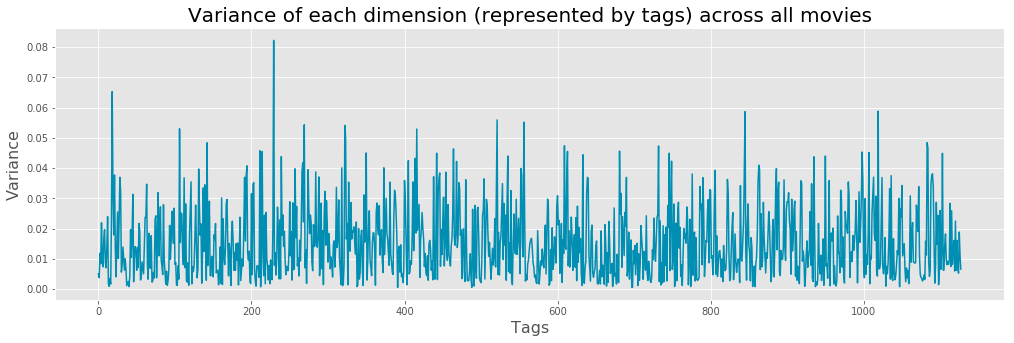

In [6]:
# Compute the variance of each tag across all movies
tags_variance = np.var(matrix,axis=1)


# Plot the variance
plt.figure(figsize=(17, 5))
plt.plot(tags_variance, color="#008eb2")
plt.xlabel('Tags', fontsize=16)
plt.ylabel('Variance', fontsize=16)
plt.title("Variance of each dimension (represented by tags) across all movies", fontsize=20)
plt.show()

We build the covariance matrix, which has a (M x M)-shape.

In [7]:
# Center the data matrix
mean = matrix.mean(axis=1)
centered_matrix = matrix - mean.reshape(-1, 1)


# Compute the covariance matrix
covMatrix = np.cov(centered_matrix)
covMatrix.shape

(1128, 1128)

We compute the eigenvalues of the covariance matrix.

In [8]:
# Compute the eigenvectors & eigenvalues
eigenvalues, eigenvectors = la.eigh(covMatrix)


# Sort the eigenvectors & eigenvalues in descending order
order = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[order]
eigenvectors = eigenvectors[:, order]

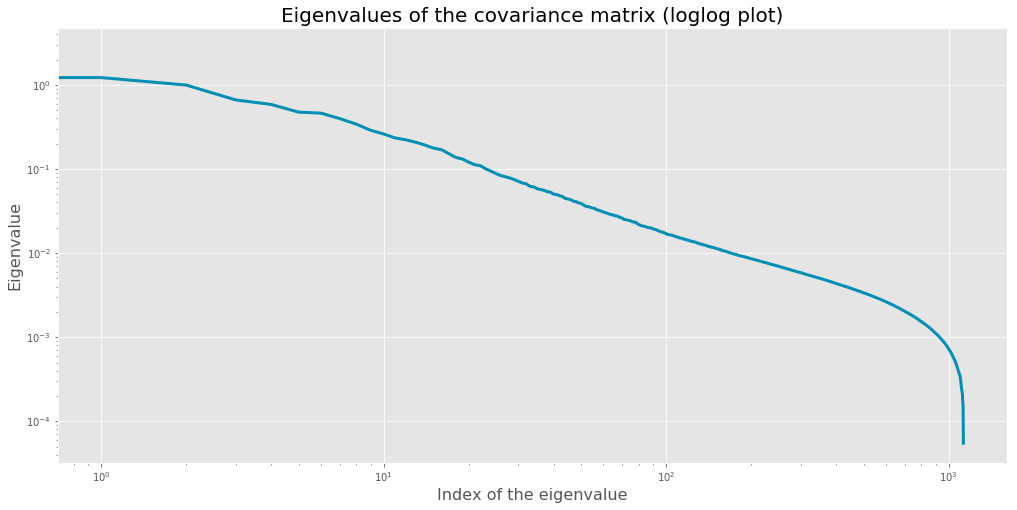

In [9]:
# Plot the eigenvalues
plt.figure(figsize=(17, 8))
plt.loglog(eigenvalues, color='#008eb2', linewidth=3)
plt.xlabel('Index of the eigenvalue', fontsize=16)
plt.ylabel('Eigenvalue', fontsize=16)
plt.title("Eigenvalues of the covariance matrix (loglog plot)", fontsize=20)
plt.show()

Interpretation: Only a few eigenvalues out of 1128 are big, while most of them are very small. This means that dimensionality reduction is relevant: representing the data in a lower dimension and at the same time preserving the variability of the data is feasible.

Let's see how many principal directions we need to capture 2/3 of the variability in the data.

In [10]:
# Compute the number of principal directions for 2/3 of the variability preserved
threshold = 2/3
# Since the numpy 'argmin' function returns an index, we add 1 to the result
directionCount = np.argmin(eigenvalues.cumsum() < threshold * np.sum(eigenvalues)) + 1
print(f"To capture 2/3 of the variability in the data, we need {directionCount} principal directions.")

To capture 2/3 of the variability in the data, we need 37 principal directions.


### Exercice 3.2 -  Concept Space

For the five first principal directions, we find the 10 tags that have the highest and lowest coordinates in that direction.

In [11]:
numberOfDirection = 5
numberOfTags = 10

# Select the five first eigenvectors for the PCA
pca_directions = eigenvectors[:, : numberOfDirection]
pca_coordinates = pca_directions.T

#Python dict which maps every tag (name) to its coordinates in the 5 first 
#principal directions
tagNewCoordinates = {}
for i in range(M):
    tagNewCoordinates[i+1] = pca_coordinates[:, i].tolist()
    
# Save it to disk
# with open("tagNewCoordinates.txt", "w") as fp:
#    json.dump(tagNewCoordinates, fp)  # encode dict into JSON

In [12]:
# Helper function to retrieve the tag name from the tag id
def tag2nameFunc(x):
    func = np.vectorize(lambda x: tag2name[x+1])
    return func(x)

# Print the 10 tags having the highest/lowest coordinates for each principal direction
for i in range(numberOfDirection):
    vector = pca_coordinates[i, :]
    args = vector.argsort()
    maxtags = tag2nameFunc(args[-10:][::-1])
    mintags = tag2nameFunc(args[:10])
    print("Principal Direction n°", i+1)
    print()
    print("Highest:", maxtags)
    print()
    print("Lowest:", mintags)
    print("\n----------\n")
    

Principal Direction n° 1

Highest: ['talky' 'social commentary' 'criterion' 'imdb top 250' 'great acting'
 'drama' 'oscar (best directing)' 'bleak' 'dramatic' 'cinematography']

Lowest: ['predictable' "so bad it's funny" 'bad plot' 'silly' 'silly fun'
 'horrible' 'franchise' 'lame' 'big budget' 'comedy']

----------

Principal Direction n° 2

Highest: ['intimate' 'relationships' 'criterion' 'melancholic' 'loneliness'
 'golden palm' 'meditative' 'art house' 'melancholy' 'sexual']

Lowest: ['action' 'special effects' 'big budget' 'chase' 'fast paced' 'suspense'
 'good action' 'plot' 'pg-13' 'action packed']

----------

Principal Direction n° 3

Highest: ['feel-good' 'sentimental' 'love story' 'heartwarming' 'touching'
 'romantic' 'sweet' 'courage' 'girlie movie' 'feel good movie']

Lowest: ['horror' 'weird' 'creepy' 'splatter' 'stylish' 'cult classic'
 'disturbing' 'violence' 'cult film' 'dark']

----------

Principal Direction n° 4

Highest: ['visual' 'visually stunning' 'imagination' 

### Exercice 3.3 -  Movie visualization

We want to visualize the movies of selected-movies.pickle on the first two principal directions.

In [13]:
# Read the .pickle file from the disk
with open("selected-movies.pickle", "rb") as f:
    selected_movies = pickle.load(f, encoding="utf-8")
selected_movies

((780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (5349, 'Spider-Man (2002)', 0.89),
 (2571, 'Matrix, The (1999)', 0.87),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (2329, 'American History X (1998)', 0.83),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (55444, 'Control (2007)', 0.87),
 (32296, 'Miss Congeniality 2: Armed and Fabulous (2005)', 0.15),
 (43930, 'Just My Luck (2006)', 0.13),
 (4658, 'Santa Sangre (1989)', 0.85),
 (6774, 'Videodrome (1983)', 0.78),
 (3967, 'Billy Elliot (2000)', 0.85),
 (114028, 'Pride (2014)', 0.92),
 (480, 'Jurassic Park (1993)', 0.93),
 (260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (527, "Schindler's List (1993)", 0.96),
 (2959, 'Fight Club (1999)', 0.79),
 (6132, 'New York Ripper, The (Squartatore di New York, Lo) (1982)', 0.17),
 (2858, 'American Beauty (1999)', 0.88),
 (6016, 'City of God (Cidade de Deus) (2002)', 0.9),
 (94018, 'Battleship (2012)', 0.34),
 (5687,

In [14]:
# Select the two first eigenvectors
pca_directions = eigenvectors[:, : 2]
pca_coordinates = pca_directions.T

In [15]:
# Retrieve the list of movieIds from the selected movies
movieIds = np.array([int(x[0]) for x in selected_movies])
movieIds

array([   780,   5349,   2571,    318,   2329,   5147,  55444,  32296,
        43930,   4658,   6774,   3967, 114028,    480,    260,   4700,
          527,   2959,   6132,   2858,   6016,  94018,   5687,   1240,
       111759,    356,  81845,   2324,   5163,   7235,   1199,  48043,
         4465,    805,  74545,  54503,   2706])

In [16]:
# Translate the movieIds to a valid index from 0 to to 10'380 (same as in 3.1)
movieIdx =[movie2idx[x] for x in movieIds]

In [17]:
# Extract from the data matrix the columns of interest for the selected movies
selected_matrix = matrix[:, movieIdx]
selected_matrix.shape

(1128, 37)

In [18]:
# Projection on the 2D lower dimension
proj = pca_coordinates @ selected_matrix
proj = proj.T # for the plot
proj.shape

(37, 2)

In [19]:
# Define colors
cmap = plt.get_cmap('plasma')
float2rgb = lambda x: rgb2hex(cmap(x)[:3])

# Define the data that appears on the bokeh plot
source = ColumnDataSource(
    data={
        "x": proj[:,0],
        "y": proj[:,1],
        "movie": np.array(selected_movies)[:,1],
        "color": [float2rgb(float(x)) for x in np.array(selected_movies)[:,2]],
    })

# Show the movie name when the mouse is over a dot
hover = HoverTool(
    tooltips=[
        ("Movie", "@movie"),
    ])

tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

# Plot the data
p = figure(plot_width=960, plot_height=360, tools=tools, title="Movies")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)